# Topic Modeling using BERTopic Approach

In [16]:
import pandas as pd
from sentence_transformers import SentenceTransformer  
#NB: Ti potrebbe servire avere pyTorch installato.
import umap        #necessario per dimensionality reduction
import umap.umap_ as umap
import hdbscan     #necessario per clustering
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

## Load the dataset

Si tratta di un database con più di 12mila canzoni etichettate come "indie" e "non indie" pubblicate tra il 2000 e il 2020, comprensivo dei testi e di alcune metriche elaborate da spotify. Importante notare che i testi sono tutti in minuscolo e sono privi di punteggiatura.

In [6]:
path = 'dataset_topic_modeling/'   
filename = 'INDIE DATABASE.csv'
data_raw = pd.read_csv(path+filename)   

#seleziono solo la parte del database che mi serve, ovvero quello con le canzoni etichettate come indie
data_indie = data_raw[data_raw['label'] == 'indie']

#creo una lista con tutti i testi
data = list(data_indie['TESTO'])

In [10]:
data[1]

' sono un tipo antisociale non m importa mai di niente  non m importa dei giudizi della gente  odio in modo naturale ogni ipocrisia morale  odio guerre ed armamenti in generale  odio il gusto del retorico il miracolo economico  il valore permanente e duraturo  radio a premi caroselli tv cine radio rallies  frigo ed auto non c è  ford nel mio futuro e voi bimbe sognatrici della vita delle attrici  attenzione da me state alla lontana  non mi piace esser per bene far la faccia che conviene  poi alla fine sono sempre senza grana l antisociale io sono un tipo antisociale l antisociale io sono un tipo antisociale  odio la vita moderna fatta a scandali e cambiali i rumori gli impegnati intellettuali  odio i fusti carrozzati dalle spider incantati  coi vestiti e le camicie tutte uguali  che non sanno che parlare di automobili e di moda  di avventure estive fatte ai monti e al mare  vuoti e pieni di sussiego se il vestito non fa un piego  mentre io mi metto quello che mi pare l antisociale io s

## Create Embeddings

In [11]:
model = SentenceTransformer('distilbert-multilingual-nli-stsb-quora-ranking')
embeddings = model.encode(data, show_progress_bar=True)

config_sentence_transformers.json: 100%|██████████| 122/122 [00:00<00:00, 1.04MB/s]
README.md: 100%|██████████| 3.85k/3.85k [00:00<00:00, 27.1MB/s]
sentence_bert_config.json: 100%|██████████| 53.0/53.0 [00:00<00:00, 307kB/s]
config.json: 100%|██████████| 589/589 [00:00<00:00, 1.60MB/s]
pytorch_model.bin: 100%|██████████| 539M/539M [00:21<00:00, 24.8MB/s] 
tokenizer_config.json: 100%|██████████| 481/481 [00:00<00:00, 1.56MB/s]
vocab.txt: 100%|██████████| 996k/996k [00:00<00:00, 4.71MB/s]
tokenizer.json: 100%|██████████| 1.96M/1.96M [00:00<00:00, 3.89MB/s]
Batches: 100%|██████████| 273/273 [01:31<00:00,  2.97it/s]


NOTA: con documenti molto grandi potrebbero esserci errori. Prova a suddividerli in singoli paragrafi!

## Clustering

### Umap - reduce dimensionality of the data(embeddings)

Nel nostro caso ridurremo la dimensionalità a 5 e manterremo la dimensione del local neighborhood a 15. Per ottimizzare la creazione di topic si può giocare con questi parametri. 

(attenzione: una dimensionalità troppo bassa porta a una perdita di informazioni, mentre una troppo alta porta a scarsi risultati di clustering).

In [17]:
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings)

In [18]:
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

## Data Visualization

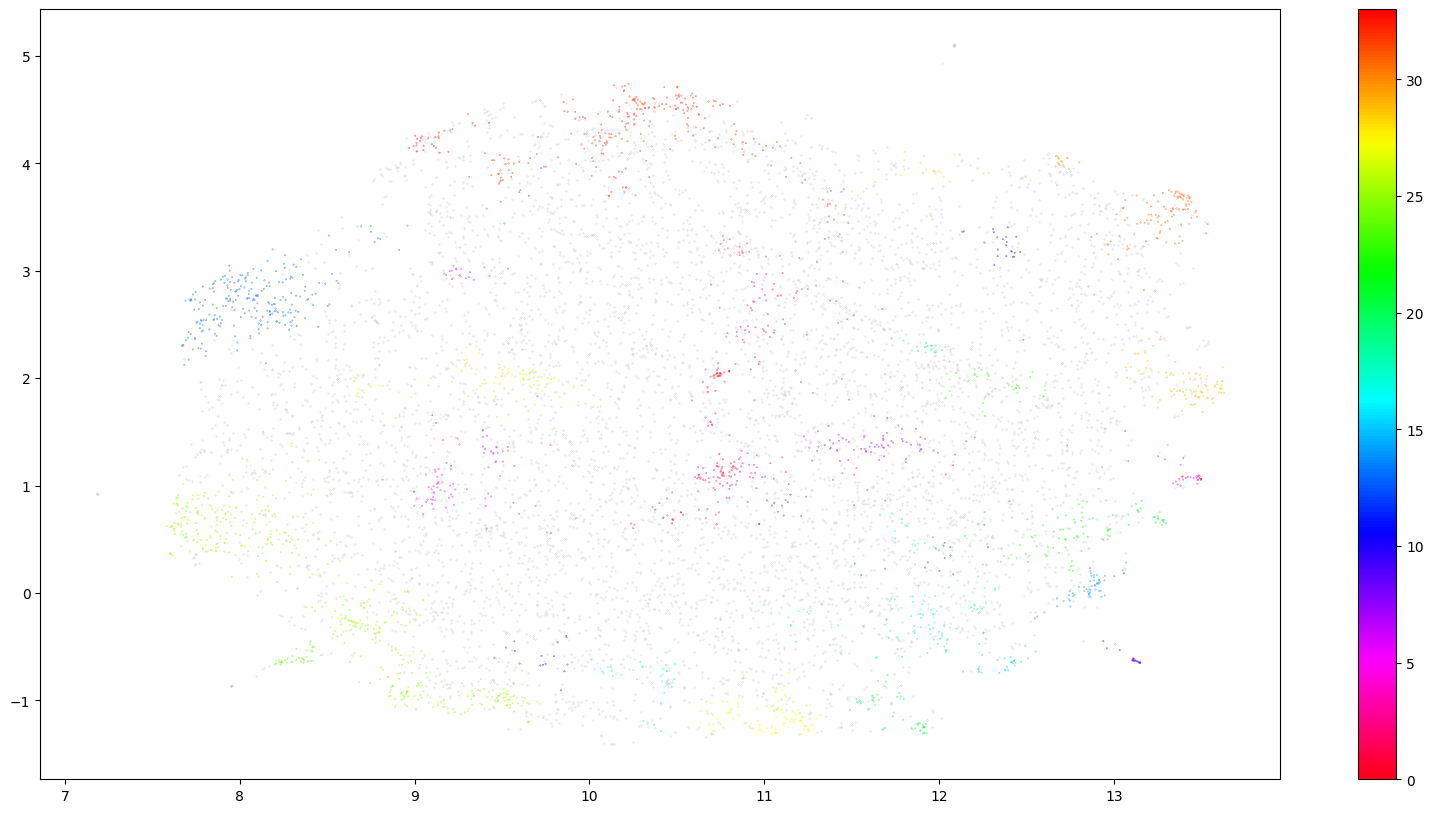

In [19]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

Possiamo osservare che ci sono circa 40 topic, e molti punti non sono stati asseganti a nessun topic (quelli in grigio).

## Creiamo i Topic

In [20]:
docs_df = pd.DataFrame(data, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))

### Tf-itf

La funzione di peso tf-idf (term frequency–inverse document frequency) è una funzione utilizzata in information retrieval per misurare l'importanza di un termine rispetto ad un documento o ad una collezione di documenti. Tale funzione aumenta proporzionalmente al numero di volte che il termine è contenuto nel documento, ma cresce in maniera inversamente proporzionale con la frequenza del termine nella collezione. L'idea alla base di questo comportamento è di dare più importanza ai termini che compaiono nel documento, ma che in generale sono poco frequenti. [wikipedia](https://it.wikipedia.org/wiki/Tf-idf)

Raggruppiamo tutti i documenti aventi lo stesso topic
- `group_by` raggruppa i documenti per topic
- `agg` li aggrega in un'unica riga

Ogni riga conterra la lista di tutti i testi che hanno lo stesso topic in comune, sepratati da uno spazio

In [29]:
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

Definiamo la funzione c_tf_idf (la *c* sta per *class-based*). Raggruppa sotto un unico documento gli elementi che appartengono allo stesso topic

In [28]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents) # rimuovo le stop words
    t = count.transform(documents).toarray() # trasformo i documenti in array
    w = t.sum(axis=1) # Total words in each document
    tf = np.divide(t.T, w) # Freq of words in each document (TF)
    sum_t = t.sum(axis=0) # Freq of words in corpus
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1) # Inverse Document Freq (IDF)
    tf_idf = np.multiply(tf, idf) # Compute the TF-IDF

    return tf_idf, count

Ora abbiamo il punteggio di importanza di ogni singola parola in un cluster. L'idea è che se stampiamo le prime 10 o 15 o 20 parole più importanti di ogni cluster, dovremmo riuscire a interpretarne il significato.

In [30]:
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

### Visualize (not working ?)

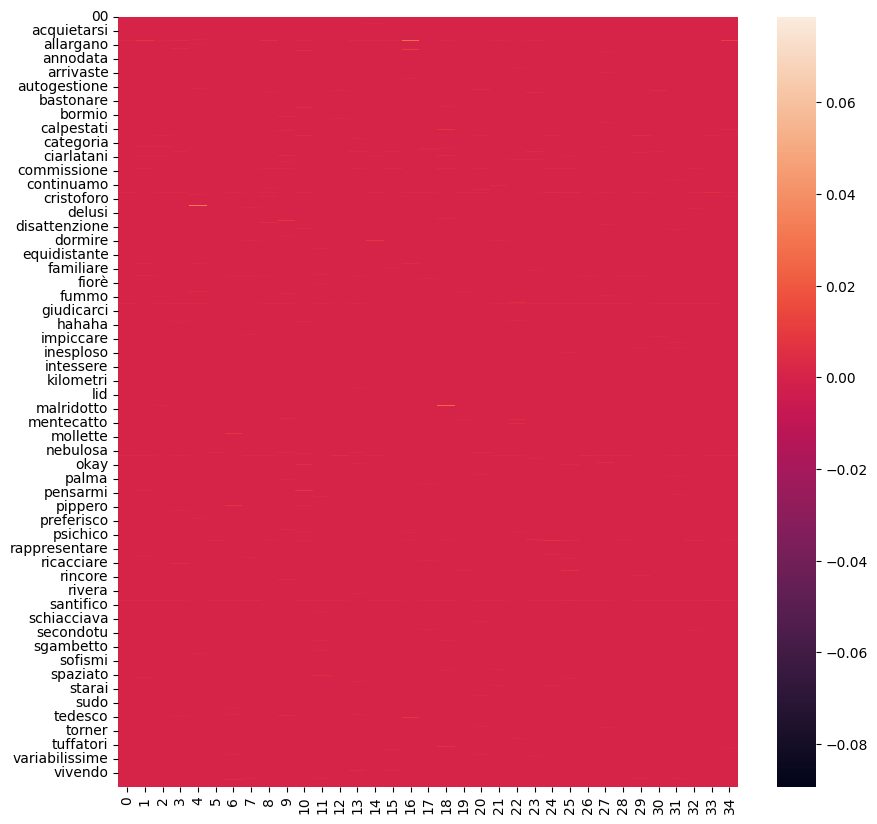

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Generate the TF-IDF matrix
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

# Convert the matrix to a DataFrame for easier visualization
tf_idf_df = pd.DataFrame(tf_idf, index=count.get_feature_names_out())

# Plot the heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(tf_idf_df)
plt.show()

## Evaluation

Stampiamo le top 20 parole per ogni topic basandociu sullo score di prima

In [38]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(15)

,Topic,Size
0,-1,6343
26,25,444
33,32,284
14,13,240
2,1,115
32,31,99
28,27,97
27,26,87
30,29,86
19,18,82


15 parole più importanti del topic 4

In [40]:
top_n_words[4][:15]

[('aveva', 0.024836382710559837),
 ('spenti', 0.020348329369365144),
 ('custode', 0.020122582915385743),
 ('volto', 0.019201166463648563),
 ('faccia', 0.01783801776483792),
 ('attento', 0.01653097851032318),
 ('eheh', 0.015804480778403126),
 ('fiondarsi', 0.015216867192860023),
 ('sofferenti', 0.015216867192860023),
 ('mendicanti', 0.014894713212029809),
 ('voleva', 0.014220124814464786),
 ('ghiaccia', 0.013768283743413953),
 ('angelo', 0.01351471114636491),
 ('botte', 0.012493523779872074),
 ('continuano', 0.012152421908025277)]